In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Creating a mock catalogue with Galaxia**
Galaxia needs an input parameter file which I have prepared in the input folder. It will sample 10% of the stars with an apparent V magnitude brighter than 11th mag (without extinction). Have a look at the file and compare with the Galaxia instructions [http://galaxia.sourceforge.net/Galaxia3pub.html].

In [2]:
import subprocess
args = ['galaxia', '-r', '../input/myparameterfile']

In [3]:
## Running galaxia in the command line. This will take some time (ca. 10min).

p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)	
out, err = p.communicate()
print(err)
print(out)


CODEDATAPATH=/home/jan/GalaxiaData/
Reading Parameter file-             ../input/myparameterfile
--------------------------------------------------------
outputFile               TGAS_11Vmag             
outputDir                ./../output             
photoSys                 UBV                     
magcolorNames            V,B-V                   
appMagLimits[0]          -1000                   
appMagLimits[1]          11                      
absMagLimits[0]          -1000                   
absMagLimits[1]          1000                    
colorLimits[0]           -1000                   
colorLimits[1]           1000                    
geometryOption           0                       
longitude                0                       
latitude                 90                      
surveyArea               1000                    
fSample                  0.1                     
popID                    -1                      
warpFlareOn              1                   

You can add other photometric systems using 

```
galaxia -a --psys=photometricSystem galaxy1.ebf
```
for photometric system you can use SDSS, UBV or Gaia which are in the Galaxia isochrones folder. Though for Gaia you will have to download tables from [http://stev.oapd.inaf.it/cgi-bin/cmd] where you can also update the existing ones. Maybe Morgan [https://github.com/mfouesneau] can help with automatic query of that website.

In [14]:
# Now we want to convert the ebf file to numpy files
import os
import sys
path = os.path.abspath('../library/')
if path not in sys.path:
    sys.path.append(path)

from convert_to_recarray import convert
# Reading in the Catalogue and converting it to npy file. (If you added photometric bands then you will have to edit the convert routine)

import ebf
bes = ebf.read('../output/TGAS_11Vmag.ebf','/')
x = convert(bes)
print(len(x))
print(x.dtype.names)

193657
('rad', 'exbv_solar', 'teff', 'mag2', 'mag1', 'mag0', 'satid', 'vx', 'vy', 'vz', 'mtip', 'pz', 'px', 'py', 'feh', 'exbv_schlegel', 'lum', 'exbv_schlegel_inf', 'mact', 'glon', 'popid', 'glat', 'alpha', 'smass', 'ubv_r', 'ubv_u', 'partid', 'ubv_v', 'age', 'grav', 'ubv_b', 'ubv_i', 'ubv_h', 'ubv_k', 'ubv_j', 'fieldid')


In [15]:
# We could add ra and dec

from astropy.coordinates import SkyCoord
from astropy import units as u
from numpy.lib.recfunctions import append_fields

x = append_fields(x,('ra','dec'),(np.zeros(len(x)),np.zeros(len(x))),usemask=False)
c = SkyCoord(b=x['glat'], l=x['glon'], frame = 'galactic', unit=(u.deg, u.deg))
x['ra'] = c.icrs.ra.deg
x['dec'] = c.icrs.dec.deg

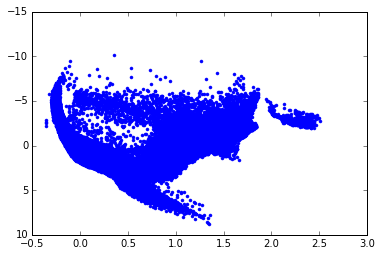

In [16]:
plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

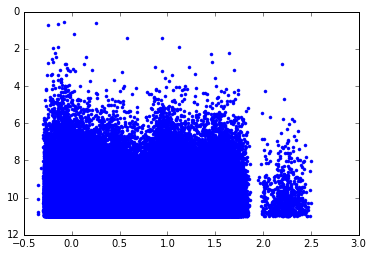

In [17]:
## Turning absolute into apparent magnitudes

filternames = ['ubv_u','ubv_b','ubv_v','ubv_r','ubv_i','ubv_j','ubv_h','ubv_k']
for band in filternames:
    x[band] += 5 * np.log10(x['rad']*1000.) - 5

plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

In [18]:
## Optional you can use extinctions from Bovy 2016 python package mwdust (using Green2015, Marshall2006 and Schlegel)
'''
from make_bovy_extinction import apply_bovy_extinction
x = apply_bovy_extinction(x)
'''

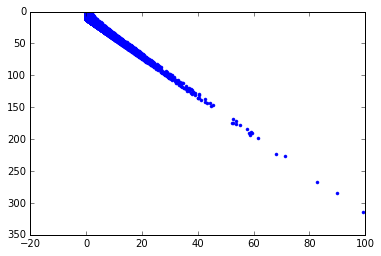

In [19]:
# Adding extinctions on top

extinction_coefficients = [4.334, 3.626, 2.742, 2.169, 1.505, 0.709, 0.449, 0.302] #List from Schlafly & Finkbeiner 2011
for i,band in enumerate(filternames):
    x[band] += x['exbv_schlegel'] * extinction_coefficients[i]

plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

193657
104194


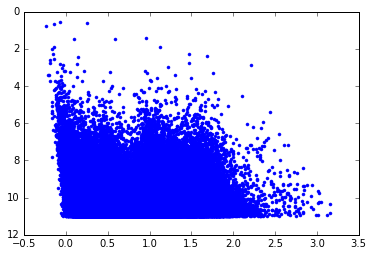

In [20]:
# Now create a mag limited sample roughly half of the sample will be lost due to extinction

print(len(x))
cut = (x['ubv_v']<11.0)
x = x[cut]
print(len(x))

plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

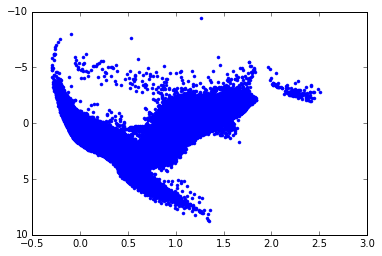

In [21]:
# Converting back into absolute magnitudes

v_abs = x['ubv_v'] - 5 * np.log10(x['rad']*1000.) + 5 - x['exbv_schlegel'] * 2.742 
b_abs = x['ubv_b'] - 5 * np.log10(x['rad']*1000.) + 5 - x['exbv_schlegel'] * 3.626 
plt.plot(b_abs-v_abs, v_abs,'.')
plt.gca().invert_yaxis()

In [22]:
np.save('../output/TGAS_11mag',x)

# save it as fits to inspect this in topcat
#from astropy.io import fits
#fits.writeto('TGAS_11mag.fits',x)